In [1]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from core.multi_asset_loader import load_assets
from core.portfolio.portfolio_manager_v2 import PortfolioManagerV2
from core.benchmark import BenchmarkLoader, BenchmarkComparator
from signals.momentum import MomentumSignalV2
from signals.trend_following_long_short import TrendFollowingLongShort
from signals.ensemble import AdaptiveEnsemble

pd.set_option('display.max_columns', None)
print("✅ Setup complete")

✅ Setup complete


## 1. Load SPY Data (Direct Trading)

We'll trade SPY directly to have a fair comparison with SPY buy-and-hold.

In [2]:
# Load SPY data
print("📊 Loading SPY data...")
prices = load_assets(
    tickers=['ES', 'GC', 'NQ'],
    start_date='2015-01-01',
    end_date='2024-12-31'
)

print(f"\n✅ Data loaded:")
for ticker, df in prices.items():
    print(f"   {ticker}: {len(df)} days ({df.index[0].date()} to {df.index[-1].date()})")

📊 Loading SPY data...

Loading 3 assets: ['ES', 'GC', 'NQ']
  📡 CSV data is 331 days old, fetching recent data from yfinance...
  ✓ Added 228 days from yfinance (now through 2025-11-27)
✓ ES: 6362 rows, 2000-09-18 to 2025-11-27
  📡 CSV data is 331 days old, fetching recent data from yfinance...
  ✓ Added 228 days from yfinance (now through 2025-11-27)
✓ GC: 6334 rows, 2000-08-30 to 2025-11-27
  📡 CSV data is 331 days old, fetching recent data from yfinance...
  ✓ Added 228 days from yfinance (now through 2025-11-27)
✓ NQ: 6362 rows, 2000-09-18 to 2025-11-27

Common date range: 2000-09-18 to 2025-11-27
Filtered date range: 2015-01-01 to 2024-12-31

Total unique dates: 2515
  GC: 2 missing dates, filled 2, 0 remain

ALIGNMENT SUMMARY
ES: 2515/2515 valid dates (100.0%)
GC: 2515/2515 valid dates (100.0%)
NQ: 2515/2515 valid dates (100.0%)

✅ Data loaded:
   ES: 2515 days (2015-01-02 to 2024-12-31)
   GC: 2515 days (2015-01-02 to 2024-12-31)
   NQ: 2515 days (2015-01-02 to 2024-12-31)
  ✓ A

## 2. Test Signal #1: Trend Following Long-Short

This signal combines:
- Fast + slow momentum (20 day + 100 day)
- Volume confirmation (needs 10% above average)
- Volatility regime filter (no trading in high vol)
- Can go LONG, SHORT, or FLAT

In [5]:
spy_data = prices["ES"]


In [6]:
# Generate Trend Following Long-Short signals
print("🎯 Generating TrendFollowingLongShort signals...")

tf_signal = TrendFollowingLongShort(
    fast_period=20,
    slow_period=100,
    volume_period=50,
    momentum_threshold=0.02,  # 2% threshold for entry
    volume_multiplier=1.1,     # Need 10% above avg volume
    vol_percentile=0.70        # Only trade below 70th percentile volatility
)

spy_with_tf_signals = tf_signal.generate(spy_data.copy())

# Display signal summary
print(f"\n📊 Signal Summary:")
signal_counts = spy_with_tf_signals['Signal'].value_counts().sort_index()
print(f"   Long positions:  {signal_counts.get(1, 0)} days ({signal_counts.get(1, 0)/len(spy_with_tf_signals)*100:.1f}%)")
print(f"   Flat positions:  {signal_counts.get(0, 0)} days ({signal_counts.get(0, 0)/len(spy_with_tf_signals)*100:.1f}%)")
print(f"   Short positions: {signal_counts.get(-1, 0)} days ({signal_counts.get(-1, 0)/len(spy_with_tf_signals)*100:.1f}%)")

print(f"\n💡 Key Indicators:")
print(f"   Avg Fast Momentum: {spy_with_tf_signals['FastMomentum'].mean():.2%}")
print(f"   Avg Slow Momentum: {spy_with_tf_signals['SlowMomentum'].mean():.2%}")
print(f"   Avg Volume Ratio: {spy_with_tf_signals['VolumeRatio'].mean():.2f}x")
print(f"   Avg Volatility: {spy_with_tf_signals['Volatility'].mean():.2%}")

display(spy_with_tf_signals[['Close', 'FastMomentum', 'SlowMomentum', 'VolumeRatio', 'Signal']].tail(10))

🎯 Generating TrendFollowingLongShort signals...

📊 Signal Summary:
   Long positions:  1513 days (60.2%)
   Flat positions:  877 days (34.9%)
   Short positions: 125 days (5.0%)

💡 Key Indicators:
   Avg Fast Momentum: 0.98%
   Avg Slow Momentum: 4.69%
   Avg Volume Ratio: 1.01x
   Avg Volatility: 15.56%


,Close,FastMomentum,SlowMomentum,VolumeRatio,Signal
Date,,,,,
2024-12-17,6053.750000,0.022593,0.100882,0.841252,1
2024-12-18,5872.250000,-0.011198,0.067100,0.643511,1
2024-12-19,5868.750000,-0.011621,0.072407,0.407637,1
2024-12-20,5840.259766,-0.021814,0.050784,1.760347,1
2024-12-23,6036.000000,0.008184,0.101410,1.051368,0
2024-12-24,6098.000000,0.015233,0.134301,0.476261,0
2024-12-26,6095.250000,0.009440,0.168232,0.689188,0
2024-12-27,6027.000000,0.001995,0.144458,1.227764,0
2024-12-30,5958.750000,-0.015327,0.139885,1.172465,0


## 3. Test Signal #2: Adaptive Ensemble

Combines multiple strategies with dynamic weighting based on performance:
- Momentum (60-day lookback)
- Trend Following Long-Short
- Weights adjust every 20 days based on rolling Sharpe ratios

In [7]:
# Create ensemble combining momentum + trend following
print("🎯 Generating Adaptive Ensemble signals...")

strategies = [
    ('momentum', MomentumSignalV2(lookback=60, entry_threshold=0.02), 0.5),
    ('trend_ls', TrendFollowingLongShort(fast_period=20, slow_period=100), 0.5)
]

ensemble_signal = AdaptiveEnsemble(
    strategies=strategies,
    method='adaptive',              # Dynamically adjust weights
    adaptive_lookback=60,           # 60-day performance window
    signal_threshold=0.3,           # Need 30% confidence to trade
    rebalance_frequency=20          # Update weights every 20 days
)

spy_with_ensemble = ensemble_signal.generate(spy_data.copy())

# Display signal summary
print(f"\n📊 Signal Summary:")
signal_counts = spy_with_ensemble['Signal'].value_counts().sort_index()
print(f"   Long positions:  {signal_counts.get(1, 0)} days ({signal_counts.get(1, 0)/len(spy_with_ensemble)*100:.1f}%)")
print(f"   Flat positions:  {signal_counts.get(0, 0)} days ({signal_counts.get(0, 0)/len(spy_with_ensemble)*100:.1f}%)")
print(f"   Short positions: {signal_counts.get(-1, 0)} days ({signal_counts.get(-1, 0)/len(spy_with_ensemble)*100:.1f}%)")

print(f"\n💡 Component Signals:")
print(f"   Momentum long: {(spy_with_ensemble['momentum_Signal'] == 1).sum()} days")
print(f"   Momentum short: {(spy_with_ensemble['momentum_Signal'] == -1).sum()} days")
print(f"   TrendLS long: {(spy_with_ensemble['trend_ls_Signal'] == 1).sum()} days")
print(f"   TrendLS short: {(spy_with_ensemble['trend_ls_Signal'] == -1).sum()} days")

print(f"\n📊 Latest Weights:")
if 'momentum_Weight' in spy_with_ensemble.columns:
    latest_mom_weight = spy_with_ensemble['momentum_Weight'].iloc[-1]
    latest_tf_weight = spy_with_ensemble['trend_ls_Weight'].iloc[-1]
    print(f"   Momentum: {latest_mom_weight:.1%}")
    print(f"   TrendLS: {latest_tf_weight:.1%}")

display(spy_with_ensemble[['Close', 'momentum_Signal', 'trend_ls_Signal', 'CombinedSignal', 'Signal']].tail(10))

🎯 Generating Adaptive Ensemble signals...

📊 Signal Summary:
   Long positions:  2395 days (95.2%)
   Flat positions:  120 days (4.8%)
   Short positions: 0 days (0.0%)

💡 Component Signals:
   Momentum long: 2395 days
   Momentum short: 0 days
   TrendLS long: 1513 days
   TrendLS short: 125 days

📊 Latest Weights:
   Momentum: 72.6%
   TrendLS: 27.4%

📊 Signal Summary:
   Long positions:  2395 days (95.2%)
   Flat positions:  120 days (4.8%)
   Short positions: 0 days (0.0%)

💡 Component Signals:
   Momentum long: 2395 days
   Momentum short: 0 days
   TrendLS long: 1513 days
   TrendLS short: 125 days

📊 Latest Weights:
   Momentum: 72.6%
   TrendLS: 27.4%


,Close,momentum_Signal,trend_ls_Signal,CombinedSignal,Signal
Date,,,,,
2024-12-17,6053.750000,1.0,1,1.000000,1
2024-12-18,5872.250000,1.0,1,1.000000,1
2024-12-19,5868.750000,1.0,1,1.000000,1
2024-12-20,5840.259766,1.0,1,1.000000,1
2024-12-23,6036.000000,1.0,0,0.726146,1
2024-12-24,6098.000000,1.0,0,0.726146,1
2024-12-26,6095.250000,1.0,0,0.726146,1
2024-12-27,6027.000000,1.0,0,0.726146,1
2024-12-30,5958.750000,1.0,0,0.726146,1


## 4. Run Backtests

Test both strategies with $100k starting capital.

In [8]:
# Backtest both strategies
initial_capital = 100000

results = {}

# Strategy 1: Trend Following Long-Short
print("🔄 Running backtest: Trend Following Long-Short...")
pm_tf = PortfolioManagerV2(
    initial_capital=initial_capital,
    risk_per_trade=0.02,
    max_position_size=1.0,
    transaction_cost_bps=3.0,
    slippage_bps=2.0
)

signals_tf = {'SPY': spy_with_tf_signals}
prices_tf = {'SPY': spy_data}
result_tf = pm_tf.run_backtest(signals_tf, prices_tf)
results['Trend_LS'] = result_tf

print(f"✅ Trend Following: ${result_tf.final_equity:,.2f}")
print(f"   Return: {result_tf.metrics['Total Return']:.2%}")
print(f"   Sharpe: {result_tf.metrics['Sharpe Ratio']:.2f}")

# Strategy 2: Adaptive Ensemble
print(f"\n🔄 Running backtest: Adaptive Ensemble...")
pm_ensemble = PortfolioManagerV2(
    initial_capital=initial_capital,
    risk_per_trade=0.02,
    max_position_size=1.0,
    transaction_cost_bps=3.0,
    slippage_bps=2.0
)

signals_ensemble = {'SPY': spy_with_ensemble}
prices_ensemble = {'SPY': spy_data}
result_ensemble = pm_ensemble.run_backtest(signals_ensemble, prices_ensemble)
results['Ensemble'] = result_ensemble

print(f"✅ Ensemble: ${result_ensemble.final_equity:,.2f}")
print(f"   Return: {result_ensemble.metrics['Total Return']:.2%}")
print(f"   Sharpe: {result_ensemble.metrics['Sharpe Ratio']:.2f}")

🔄 Running backtest: Trend Following Long-Short...
✅ Trend Following: $250,417.17
   Return: 150.42%
   Sharpe: 0.78

🔄 Running backtest: Adaptive Ensemble...
✅ Ensemble: $280,513.04
   Return: 180.51%
   Sharpe: 0.57


## 5. Load SPY Benchmark (Buy & Hold)

Compare against simple buy-and-hold strategy.

In [9]:
# Load benchmark
print("📊 Loading SPY Benchmark...")
benchmark_loader = BenchmarkLoader(cache_dir="/Users/Sakarias/QuantTrading/Dataset")
benchmark_data = benchmark_loader.load_benchmark('SPY', start_date='2015-01-01', end_date='2024-12-31')

# Scale benchmark to initial capital
benchmark_scaled = pd.DataFrame(index=benchmark_data.index)
benchmark_scaled['TotalValue'] = benchmark_data['TotalValue'] * (initial_capital / 100.0)

print(f"✅ Benchmark loaded")
print(f"   Initial: ${benchmark_scaled['TotalValue'].iloc[0]:,.0f}")
print(f"   Final: ${benchmark_scaled['TotalValue'].iloc[-1]:,.0f}")
print(f"   Return: {(benchmark_scaled['TotalValue'].iloc[-1] / benchmark_scaled['TotalValue'].iloc[0] - 1):.2%}")

📊 Loading SPY Benchmark...
📥 Updating SPY benchmark data...
✅ Benchmark loaded
   Initial: $100,000
   Final: $340,814
   Return: 240.81%
✅ Benchmark loaded
   Initial: $100,000
   Final: $340,814
   Return: 240.81%


## 6. Calculate Benchmark Metrics

Calculate alpha, beta, and other metrics vs buy-and-hold SPY.

In [10]:
# Calculate metrics for both strategies
comparator = BenchmarkComparator()

print("="*80)
print("📊 STRATEGY vs BUY-AND-HOLD COMPARISON")
print("="*80)

metrics_summary = []

for name, result in results.items():
    equity = result.equity_curve
    
    # Align benchmark to strategy dates
    bench_aligned = benchmark_data.reindex(equity.index, method='ffill')
    bench_scaled = pd.DataFrame(index=bench_aligned.index)
    bench_scaled['TotalValue'] = bench_aligned['TotalValue'] * (initial_capital / 100.0)
    
    # Calculate metrics
    metrics = comparator.calculate_metrics(equity, bench_scaled, risk_free_rate=0.02)
    
    # Add strategy return
    strat_return = (equity['TotalValue'].iloc[-1] / equity['TotalValue'].iloc[0] - 1)
    metrics['Strategy Return'] = strat_return
    metrics['Strategy Name'] = name
    
    metrics_summary.append(metrics)
    
    print(f"\n🎯 {name}:")
    print(f"   Strategy Return:  {strat_return:.2%}")
    print(f"   SPY Return:       {metrics['Benchmark Return']:.2%}")
    print(f"   Relative Return:  {metrics['Relative Return']:.2%}")
    print(f"   Beta:             {metrics['Beta (Full Period)']:.3f}")
    print(f"   Alpha (Annual):   {metrics['Alpha (Annual)']:.2%}")
    print(f"   Sharpe Ratio:     {result.metrics['Sharpe Ratio']:.2f}")
    print(f"   Max Drawdown:     {result.metrics['Max Drawdown']:.2%}")
    print(f"   Correlation:      {metrics['Correlation']:.3f}")
    print(f"   Info Ratio:       {metrics['Information Ratio']:.2f}")

print("\n" + "="*80)

# Create comparison DataFrame
comparison_df = pd.DataFrame([
    {
        'Strategy': 'SPY Buy-Hold',
        'Return': metrics_summary[0]['Benchmark Return'],
        'Sharpe': np.nan,
        'Max DD': np.nan,
        'Beta': 1.000,
        'Alpha': 0.0
    },
    {
        'Strategy': 'Trend_LS',
        'Return': metrics_summary[0]['Strategy Return'],
        'Sharpe': results['Trend_LS'].metrics['Sharpe Ratio'],
        'Max DD': results['Trend_LS'].metrics['Max Drawdown'],
        'Beta': metrics_summary[0]['Beta (Full Period)'],
        'Alpha': metrics_summary[0]['Alpha (Annual)']
    },
    {
        'Strategy': 'Ensemble',
        'Return': metrics_summary[1]['Strategy Return'],
        'Sharpe': results['Ensemble'].metrics['Sharpe Ratio'],
        'Max DD': results['Ensemble'].metrics['Max Drawdown'],
        'Beta': metrics_summary[1]['Beta (Full Period)'],
        'Alpha': metrics_summary[1]['Alpha (Annual)']
    }
])

print("\n📊 SUMMARY TABLE")
display(comparison_df.style.format({
    'Return': '{:.2%}',
    'Sharpe': '{:.2f}',
    'Max DD': '{:.2%}',
    'Beta': '{:.3f}',
    'Alpha': '{:.2%}'
}).background_gradient(subset=['Return', 'Sharpe', 'Alpha'], cmap='RdYlGn'))

📊 STRATEGY vs BUY-AND-HOLD COMPARISON

🎯 Trend_LS:
   Strategy Return:  150.42%
   SPY Return:       240.81%
   Relative Return:  -90.40%
   Beta:             0.308
   Alpha (Annual):   4.04%
   Sharpe Ratio:     0.78
   Max Drawdown:     -12.55%
   Correlation:      0.548
   Info Ratio:       -0.28

🎯 Ensemble:
   Strategy Return:  180.51%
   SPY Return:       240.81%
   Relative Return:  -60.30%
   Beta:             0.951
   Alpha (Annual):   -1.41%
   Sharpe Ratio:     0.57
   Max Drawdown:     -34.12%
   Correlation:      0.960
   Info Ratio:       -0.40


📊 SUMMARY TABLE


,Strategy,Return,Sharpe,Max DD,Beta,Alpha
0,SPY Buy-Hold,240.81%,nan,nan%,1.000,0.00%
1,Trend_LS,150.42%,0.78,-12.55%,0.308,4.04%
2,Ensemble,180.51%,0.57,-34.12%,0.951,-1.41%


## 7. Visualize Results

Plot all equity curves together.

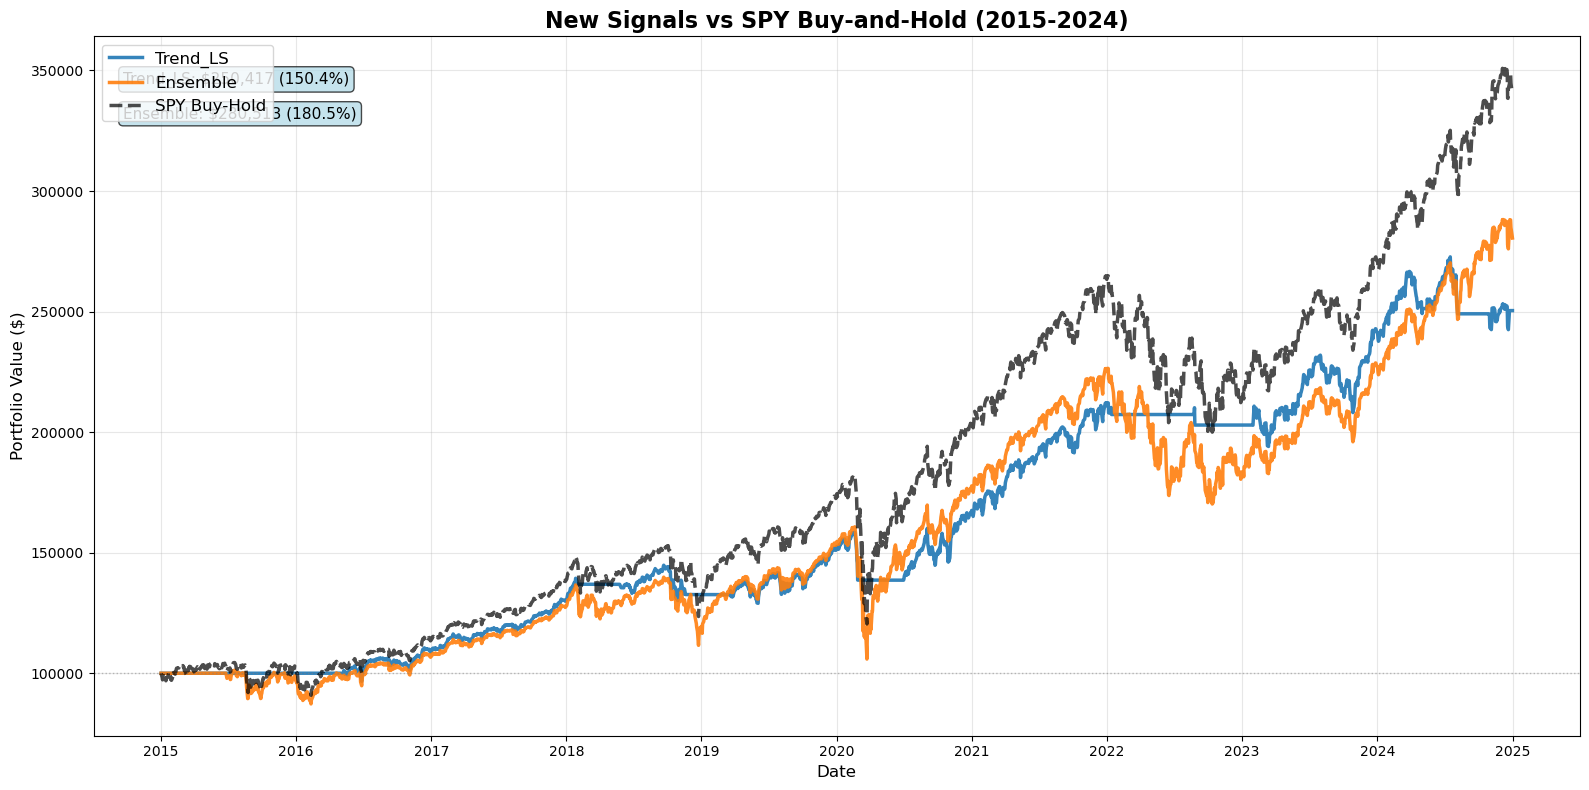


🎯 Which strategy beat SPY?
   Trend_LS: ❌ NO (150.42% vs 240.81%)
   Ensemble: ❌ NO (180.51% vs 240.81%)


In [11]:
# Plot all strategies + benchmark
fig, ax = plt.subplots(figsize=(16, 8))

# Plot strategies
for name, result in results.items():
    equity = result.equity_curve
    ax.plot(equity.index, equity['TotalValue'], 
            label=name, linewidth=2.5, alpha=0.9)

# Plot benchmark
ax.plot(benchmark_scaled.index, benchmark_scaled['TotalValue'],
        label='SPY Buy-Hold', linewidth=2.5, color='black', linestyle='--', alpha=0.7)

# Formatting
ax.set_title('New Signals vs SPY Buy-and-Hold (2015-2024)', fontsize=16, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Portfolio Value ($)', fontsize=12)
ax.legend(fontsize=12, loc='upper left')
ax.grid(True, alpha=0.3)
ax.axhline(y=initial_capital, color='gray', linestyle=':', linewidth=1, alpha=0.5)

# Add annotations
for name, result in results.items():
    final_val = result.equity_curve['TotalValue'].iloc[-1]
    ret = (final_val / initial_capital - 1)
    ax.text(0.02, 0.95 - list(results.keys()).index(name) * 0.05, 
            f'{name}: ${final_val:,.0f} ({ret:.1%})', 
            transform=ax.transAxes, fontsize=11, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))

plt.tight_layout()
plt.show()

print("\n🎯 Which strategy beat SPY?")
for name, result in results.items():
    ret = result.metrics['Total Return']
    spy_ret = metrics_summary[list(results.keys()).index(name)]['Benchmark Return']
    beat_spy = "✅ YES" if ret > spy_ret else "❌ NO"
    print(f"   {name}: {beat_spy} ({ret:.2%} vs {spy_ret:.2%})")

## 8. Summary & Next Steps

**Key Questions:**
1. Did we beat SPY buy-and-hold?
2. What's our alpha (risk-adjusted excess return)?
3. Is our Sharpe ratio higher?
4. Is our max drawdown lower?

**If We Beat SPY:**
- Commit to GitHub ✅
- Add to multi-strategy portfolio
- Generate reports

**If We Didn't Beat SPY:**
- Analyze what went wrong
- Adjust parameters (momentum thresholds, volume filters, etc.)
- Try different signal combinations
- Consider transaction costs impact

**Potential Improvements:**
1. Add regime detection (bull/bear/sideways)
2. Implement dynamic position sizing based on signal strength
3. Add more strategies to ensemble (volatility arbitrage, pairs trading)
4. Optimize parameters via walk-forward analysis
5. Test on different time periods (out-of-sample)